## Assignment A2b: Photon Detection

Please follow the General Assignment Guidelines document on canvas under the Pages for completing this assignment.  When you have completed the assignment, please follow the Submission Instructions.

### Overview

This assignment focuses on the probabilistic nature of photon detection.

### Readings

The following material provides background and additional context.  It is linked in the Canvas page for this assignment.

- Field, G. D., & Sampath, A. P. (2017). Behavioural and physiological limits to vision in mammals. *Philosophical Transactions of the Royal Society B*, 372(1717).

Additional sources for the curious, but not required reading:
- Bialek, W. (2012). *Biophysics*. Princeton University Press.  Chapter 2.
- Hecht S, Shlaer S, Pirenne MH. (1942). Energy, quanta, and vision. *J. Gen. Physiol.* 25, 819–840.
- Rieke, F., & Baylor, D. (1998). Single-photon detection by rod cells of the retina. *Reviews of Modern Physics*, 70(3), 1027–1036.

### Learning objectives

- write code to generate simulated streams of photons, 
- learn to use different probability distributions
- calculate the probability of detection
- predict the number of photos required for detection based on experimental results
- fit a theoretically derived curve to experimental data

## Introduction

Experiments in photon detection require producing a dim flash of light that is right at the limit of what is perceivable. A counter intuitive aspect of detection is that it's probabilistic.  For seemingly the same light intensity, sometimes the flash is seen and sometimes it's not.  What changes is the *probability* of seeing the flash.  The question is, where does this randomness come from?  Is it the inherent variability of biology?  Are there sources of noise?  Is the observer, perhaps unconsciously, adjusting their criterion?  Could it be in the light itself?  Like most things in biology, the answer is, in varying degrees, all of the above.

To model the process of photon detection, we first have to describe the stream of photons.  This stream is inherently random.  For a light source and for reflected light in the natural world, there isn't a highly precise clock emitting an exact number photons with femtosecond precision.  The photons are generated spontaneously, at controlled rates, and are independent of each other, which means that they arrive at random intervals.  If they didn't, they wouldn't be independent. 

A statistical description of this stream is called a **Poisson process**.  Of course at a longer time scale, the flash (or the shutter that produced the flash) introduces a dependency, but for periods within the duration of the flash, the photons are random.  Much of perception is about solving a probabilistic inverse problem, and it is useful (not to mention instructive) to be able to simulate stimuli from an idealized and controllable world where we can introduce complexity as necessary.  Knowing this "ground truth", we can then use this simulated data to test different perceptional models.


***
## Exercises

In [2]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import ipywidgets as widgets
import math

## 1. Simulating a dim flash of light

We will simulate a stream of photons with a Poisson process, which can be modeled in two different ways.  One is to select the event times randomly, the other is to generate random intervals between the events.  When you run your code, run it multiple times (using control-enter in the jupyter notebook) to see that there is a wide variety of patterns.  Sometimes there are wide gaps, other times the events are tightly clustered, occasionally they are more evenly spread out.

### 1a. Random times

Write a function `randtimes(N; t1, t2)` to simulate a Poisson process by generating $N$ random times in the interval $[t_1, t_2)$.  Write a function `plotflash` to plot your results as a stem plot of the times with unit heights.

In [3]:
def randtimes(N:int=100, t1:float=0, t2:float=1):
    return np.random.uniform(t1, t2, N)

In [4]:
def plotflash(T:np.array, title:str="Photon Release based on Poisson Distribution", xlim:list=[None, None]):
    # unit heights
    ones = np.ones(shape=len(T))

    # plot
    plt.stem(T, ones)
    if xlim[0] is not None:
        plt.xlim(xlim)
    plt.xlabel("Photon Release Distribution")
    plt.ylim([-0.1, 2])
    plt.ylabel("Relative Weight of photons")
    plt.title(title)
    plt.show()

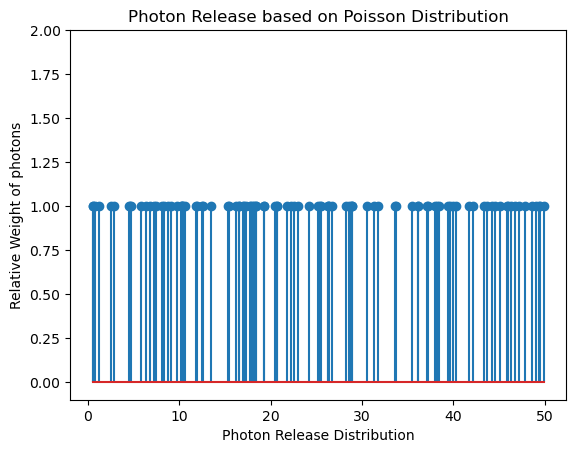

In [5]:
T = randtimes(t1=0, t2=50)
plotflash(T)

### 1b. Random intevals

A different way is to describe the random intervals between photons, i.e. the distribution times until the arrival of the next photon.  The distribution of intervals in a Poisson process is described by the **exponential distribution**

$$
p(\Delta t | \lambda) = \lambda e^{-\lambda \Delta t}
$$

where $\lambda$ is the average event rate, i.e. the average number events per period, e.g. one second.  Note that in some statistical packages, the distribution is characterized by a scale parameter $\theta$ which is the inverse of the rate.

Plot the pdf of the exponential distribution using a rate $\lambda=10$.

Write a function `randintervals(N; λ, t1)` that returns $N$ random event times starting at time $t_1$ by generating random intervals using an exponential distribution with rate $\lambda$.  Plot your results using the function you wrote above. (Aside: Naming purists might object that this function is misnamed since it returns the times, not the intervals, but randtimes_using_intervals seems excessive.)

In [6]:
def randintervals(N:int=100, lam:float=1, t1:int=0):
    t = t1; T = []
    for n in range(N):
        T.append(t + np.random.exponential(1/lam))
        t = T[-1]
    return np.array(T)

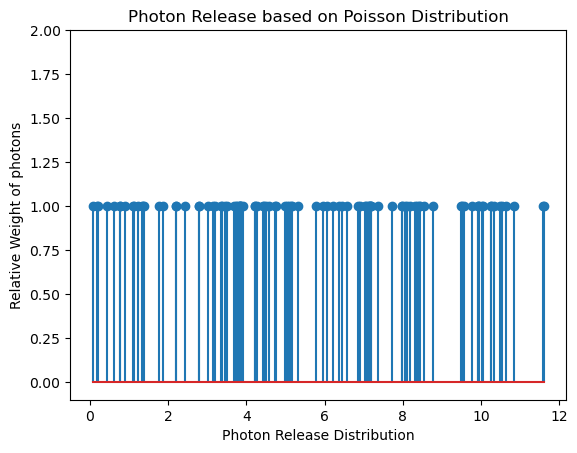

In [7]:
T = randintervals(lam=10)
plotflash(T)

### 1c. Seeing the flash

Describe the differences between the two methods above. At the visual limit, seeing a flash involves just a small number of photons.  Each photoreceptor is capable of detecting single photos, but to "see" the flash requires detecting a minimum number of photons within a certain interval to separate signal from noise.  Explain why this is inherently probabilistic.

At any given time, the cones and rods of the eye experience levels of noise. In order to separate this noise from signal and respond to the signal, they require a constant stream of photons for a given time. This is inherently probabalistic because of the non-deterministic nature of the photons entering the eye which can be perceived as either noise or signal. 

## 2. Calculating the probability detection

### 2a. The probability of K photons

The **Poisson distribution** specifies the probability of observing $n$ events at rate $\lambda$ within a unit time interval

$$
p(n | \lambda) = \frac{\lambda^n}{n!} e^{-\lambda}, \quad n=0, 1, 2, \ldots
$$

For an arbitrary time period, we simply scale the rate: a period that is twice as long will see twice as many events.

$$
p(n | \lambda, T) = \frac{(\lambda T)^n}{n!} e^{-\lambda T}, \quad n=0, 1, 2, \ldots
$$

The maximum integration period for visual detection is ~100 msecs.  Use the Poisson distribution pdf to calculate the probability of receiving a specific number of photons within the period.  

Make a bar plot of the pdf as a function of $n$. Your x-axis should be discrete and your plot should have descriptive labels.  If the threshold for seeing were 6 photons, would the subject see the flash?

Double the photon rate (i.e. the light intensity) and then double it again plotting both results.  Observe how the probability of seeing the flash increases.

In [76]:
def plotpdf(lam=10):
    # calc prob
    t = np.linspace(0.0, 10.0, 1000)
    p = lam * np.exp(-lam*t)
    prob = p / np.linalg.norm(p, ord=2)

    plt.plot(t, prob)
    plt.title("Exponential Distribution")
    plt.ylabel("$p(\Delta t | \lambda)$")
    plt.xlabel("$\Delta t$")
    plt.xlim([-0.05, 2.05])
    plt.show()

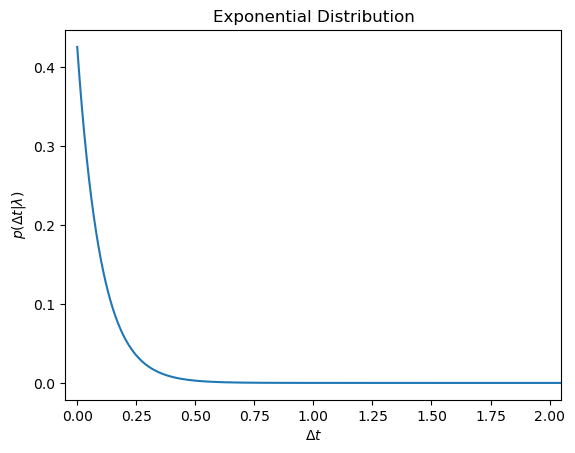

In [77]:
plotpdf()

In [8]:
@widgets.interact(lam=(0,40), T=(0.0,2.0))
def probkphotons(lam=10, T=0.1):
    # arrange values
    K = np.arange(0, 20)
    P = np.array([(lam*T)**k / math.factorial(k) * np.exp(-lam*T) for k in K])

    # plot
    plt.bar(K, P)
    plt.xlabel("n")
    plt.ylabel("p(n|$\lambda$,T)")
    plt.title("Probability of observing n events")

interactive(children=(IntSlider(value=10, description='lam', max=40), FloatSlider(value=0.1, description='T', …

Here we can set T to be 0.1 (100 msec) and change the value of lambda to approximate the probability of observing an event. At lambda=15, it is obvious that the probability of observing a rod responding to a photon is not 0, but is very close to it. Doubling lambda to 30, provides reasonable evidence to suggest that a cell might respond to a consistent stream of at least 6 photons.

### 2b. The probability of K or more photons

The Poisson distribution specifies the probability of observing *exactly* $n$ events.  Of course, we would also see the flash for any number of events exceeding the threshold, so the actual probability of seeing would be the sum of all probabilities at or above some threshold $K$.

$$
p(n \geq K | \lambda, T) = \sum_{n=K}^\infty p(n|\lambda, T)
$$

This is the complement of the **cumulative distribution function** $\textrm{cdf}(x)$ where $x=K-1$ which we can use to calculate the detection probability.  (Note that we need to be careful at the threshold to use $K-1$, because the cdf is defined by the sum *through* $x$).

Write a function `detectionprob(K; λ=40, T=0.1)` which uses the cdf to calculate the probabilities of seeing $K$ or more photons.  Make bar plot of the detection probability as a function of the detection threshold.

In [9]:
def detectionprob(K:float, lam:int=40, T:float=0.1):
    return 1 - stats.poisson.cdf(K-1, lam*T)

In [68]:
detectionprob(3, 10, 0.1)

0.08030139707139416

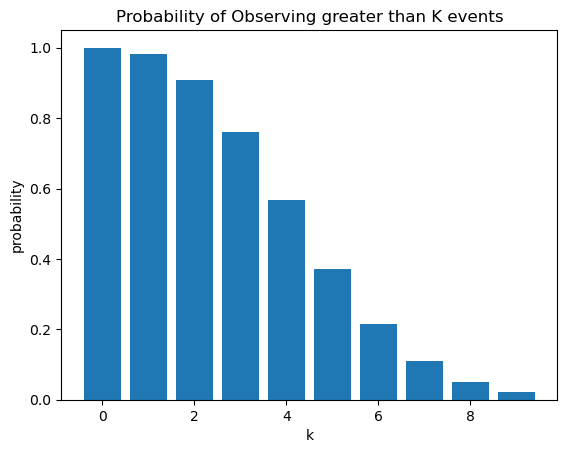

In [11]:
K = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
B = np.array([detectionprob(k, 40, 0.1) for k in K])

plt.bar(K, B)
plt.xlabel("k")
plt.ylabel("probability")
plt.title("Probability of Observing greater than K events")
plt.show()

### 3. Estimating the threshold from experimental data

There a couple details we need to address before we can apply model to experimental data.  

The first is the duration of the flash.  Experimental results show that if we have a shorter flash with the same number of photons, we have the same probability of detecting it.  This makes sense because they could all arrive simultaneously (but at different rhodopsin molecules) and would still be detected.  This doesn't hold if we make the flash too long (> ~200 ms) -- the photons will be too spread out, the resulting currents in the retinal circuitry wouldn't sum, and we wouldn't see it.  Thus, it makes sense to talk about the intensity of the flash in terms of the total number of photons without needing to specify the duration.  

The second is that only a fraction of the photons arriving at the eye are actually detected by rods.  Some are scattered, some are absorbed, some pass through the retina without being detected. Measurements in original paper by Hecht, Shlaer, and Pirenne (1942) (HSP) estimated that 4% of the incident photons are reflected by the cornea, 50% are absorbed by the lens and other ocular media, and at least 80% passes through the retina without being absorbed.  Overall, Hecht et al estimated that, for a typical flash, the range of 54 to 148 photons that arrive at the cornea, only 5 to 14 are actually absorbed by retinal rods.

### 3a. Simulating the photon stream

Define a function `lightflash(λ; t1=0.8, t2=2.2)` that returns an array of random (photon) time points at rate `λ` starting and `t1` and stopping at `t2`.  Write a function that simulates and plots the stream of photons for the three following stages:

1. The photon stream at a rate of 100 photons / msec from times f1 to f2.
2. The subset of photons that pass through a shutter which is open from times s1 to s2.
3. The subset of photons that are finally detected (or absorbed) by rods using $\alpha=0.06$.

Use this to simulate conditions similar to the original experiments of HSP who used an open shutter duration of 1 millisecond (1 ms to 2 ms) and a photon rate of $\lambda=100$ photons / msec.  Your plot should contain subplots in a stacked arrangement with appropriate titles.  The time axes should be aligned and in units of milliseconds, but you only need to include a label for the bottom subplot.

In [12]:
def lightflash(lam:float, t1:float=0, t2:float=1):
    t = t1 + np.random.exponential(scale=1/lam)
    
    PT = []
    while t < t2:
        PT.append(t)
        t += np.random.exponential(1/lam)
    return np.array(PT)

In [13]:
def plotsimulation(lam:float=100, f1:float=0.8, f2:float=2.2, s1:float=1, s2:float=2, alpha:float=0.06):
    # full sequence
    P = lightflash(lam, f1, f2)
    plotflash(P, "Photon Stream from f1 to f2", [f1-0.1, f2+0.1])

    # s1 to s2 - through shutter
    P = P[(P > s1) & (P < s2)]
    plotflash(P, "Photon Stream through shutter", [f1-0.1, f2+0.1])

    # detected by retina
    P = np.array([p for p in P if np.random.uniform() < alpha])
    plotflash(P, "Photons detected by rods", [f1-0.1, f2+0.1])

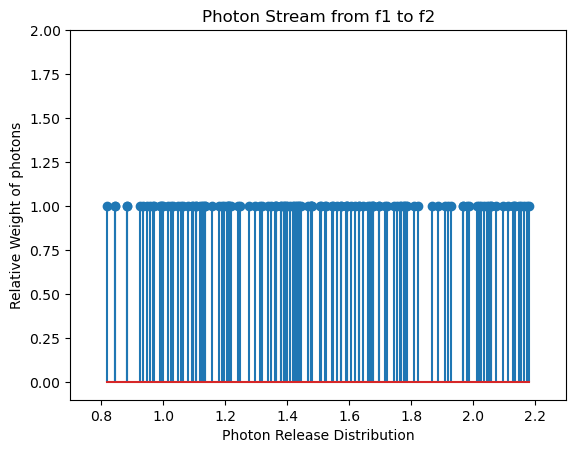

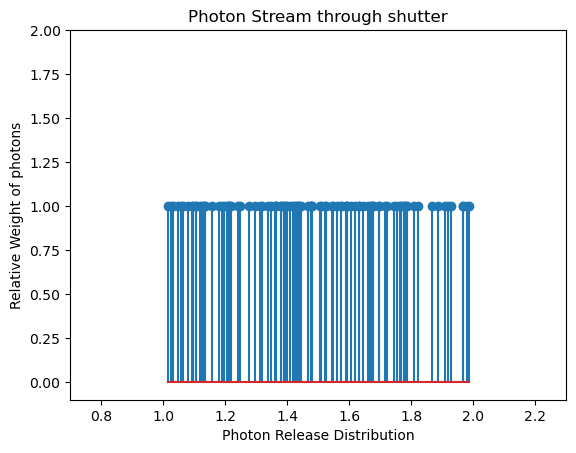

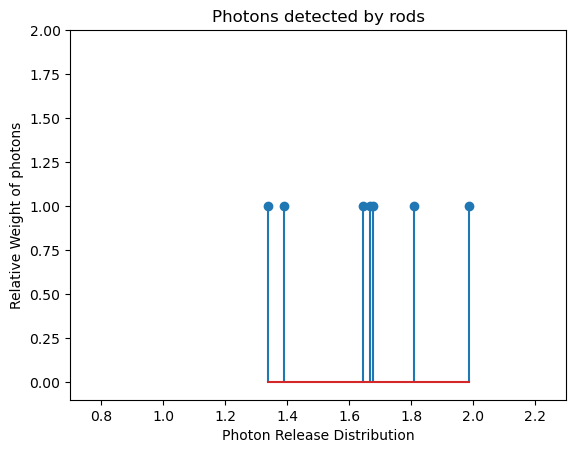

In [14]:
plotsimulation()

### 3b. Probability of seeing

To describe these combined effects, let $I$ be the total number of photons arriving at the cornea and $\alpha$ be the fraction absorbed, then the average number detected is $\alpha I$.  This gives a revised expression for the detection probability

$$
P(n \geq K | I, \alpha) = \sum_{n=K}^\infty p(n | \alpha I)
$$

Write a function `probseeing(I; α=0.06, K=6)` which implements the equation above.  Like in 2b, you should use compute this using the cumulate distribution function and the Poisson rate of photons detected.

In [15]:
def probseeing(I:float, alpha:float=0.06, K:int=6):
    return 1-stats.poisson.cdf(K-1, alpha*I)

In [16]:
probseeing(50)

0.08391794203130343

### 3c. Plotting % detected vs light intensity for different parameters

A key insight from HSP was that it was possible to estimate the detection threshold $K$ from the data of human subjects (who sat for long hours, in a completely dark chamber, detecting the dimmest possible flashes of light).  Here we will reproduce a figure from Bialek (2012) which shows that the shape of the curve depends on $K$ but not on $\alpha$.

Write a function `plotdetectioncurve(α=0.5, K=6)` that plots the percentage of light flashes detected as a function of the intensity $I$.  You will want to write this is a way that allows you to overlay multiple curves on the same plot for different values of $\alpha$ and $K$.  Make the x-axis log scale so it's easier to compare the shapes of different curves.  The x-axis should range from 0.01 to 100.

Observe how changing $K$ changes the shape of the curve, but changing $\alpha$ only shifts the curve.

In [66]:
def plotdetectioncurve(alpha:np.array=[0.15, 0.25, 0.5, 0.5], K:np.array=[6, 6, 2, 8], xlim:tuple=(0, 100), HSP:np.array=None):
    # plot alpha and k
    for i in range(len(alpha)):
        P = np.array([probseeing(I, alpha[i], K[i]) for I in np.linspace(xlim[0], xlim[1], 1000)])
        plt.plot(np.linspace(xlim[0], xlim[1], 1000), P, label=f"alpha={alpha[i]}, K={K[i]}")

    # plot hsp data
    if HSP is not None:
        plt.scatter(HSP[0], HSP[1], label="HSP scatter")

    plt.title("Probability of Detection of a Flash")
    plt.ylabel("p(Detection|Flash)")
    plt.xlabel("Intensity")
    plt.xscale("log")
    plt.legend()
    plt.show()

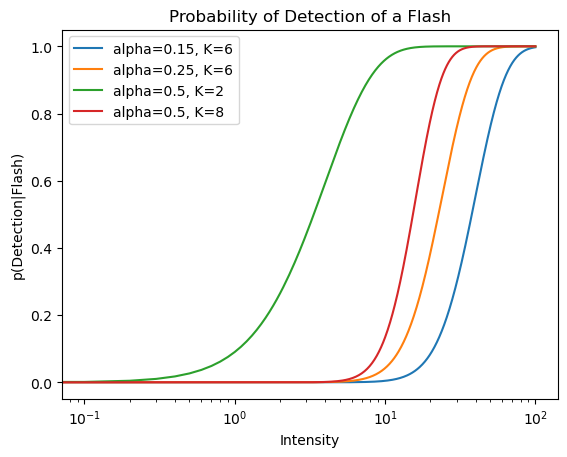

In [67]:
plotdetectioncurve()

### 3d. Fitting parameters to experimental data

Here we will reproduce the figure 2 from the review by Rieke and Baylor (1998), which also references the classic HSP paper.  

Use your plot function above to plot curves (overlaid) for the following pairs: `(α=0.02, K=2)` and `(α=0.13, K=12)`.  Now also overlay the following data points from HSP subject SS ("S" in HSP):

```
24.1, 37.6, 58.6, 91.0, 141.9, 221.3  # SS: average photons at cornea
 0.0,  4.0, 18.0, 54.0,  94.0, 100.0  # SS: percent seen
```

Now will find the values of $\alpha$ and $K$ that best fit the data.  Wrap your code above in a function `plotfit(α, K)` to make this easier.  Use the fact that $\alpha$ and $K$ will tend to co-vary (e.g. try `plotfit(α=3, K=3)`), since increasing $\alpha$ will *increase* the number of photons reaching the rods, and therefore the detection threshold must also increase to maintain the same performance curve.

What values of $\alpha$ and $K$ best match the observed data?  Plot the optimal results and a couple sub-optimal results.  How would you explain how many photons are required in order to see a dim flash of lig

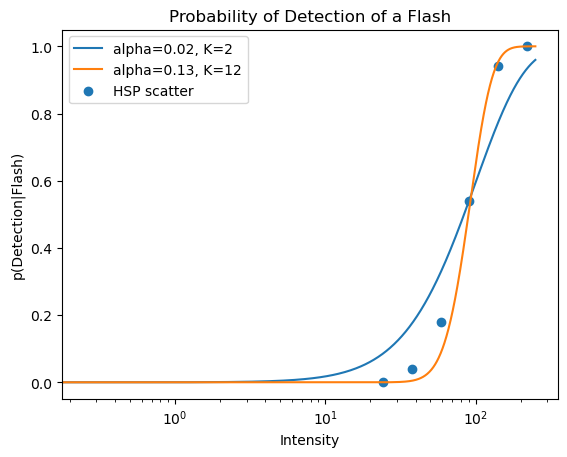

In [23]:
# set data
alpha = np.array([0.02, 0.13])
K = np.array([2, 12])
HSP = [[24.1, 37.6, 58.6, 91.0, 141.9, 221.3],
       [0.000,  0.040, 0.180, 0.540,  0.940, 1.000]]

# plot data
plotdetectioncurve(alpha, K, (0, 250), HSP)

In [53]:
def optimalfit(HSP:np.array, alpha_space:tuple=(0, 1), K_space:tuple=(1, 10)):
    # optimal params
    opt_alpha = None
    opt_K = None
    min_mse = None

    # search state space
    for a in np.linspace(alpha_space[0], alpha_space[1], 1000):
        for k in np.arange(K_space[0], K_space[1], 1):
            # calc probs and mse
            probs = np.array([probseeing(i, a, k) for i in HSP[0]])
            mse = (1/len(probs)) * np.sum((probs-HSP[1])**2)

            # re-store
            if (min_mse is None) or (mse <= min_mse):
                min_mse = mse
                opt_K = k
                opt_alpha = a

    # return
    return opt_alpha, opt_K

In [54]:
a, k = optimalfit(HSP, (0, 1), (1, 10))
print(f"optimal alpha: {a}, optimal K: {k}")

optimal alpha: 0.07707707707707707, optimal K: 7


In [57]:
def plotfit(search:bool=True, alpha:tuple=(0, 1), K:tuple=(0, 10)):
    # search for fit if specified
    HSP = [[24.1, 37.6, 58.6, 91.0, 141.9, 221.3], [0.0,  0.04, 0.18, 0.54,  0.94, 1.0]]
    opt_a, opt_k = optimalfit(HSP, alpha, K) if search else (alpha, K)

    # plot
    plotdetectioncurve([0.02, opt_a, 0.13], [2, opt_k, 12], (24.1-50, 221.3+50), HSP)

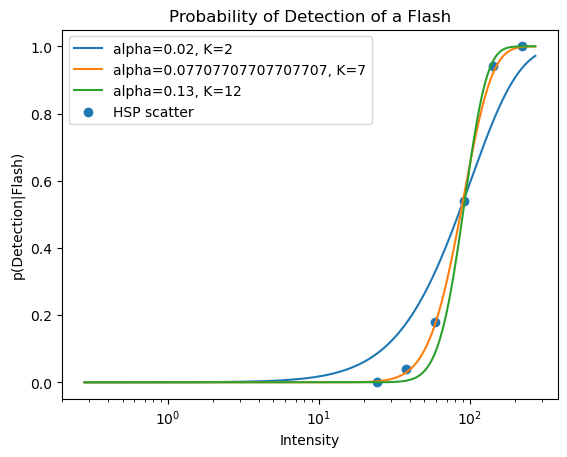

In [58]:
plotfit(search=True)

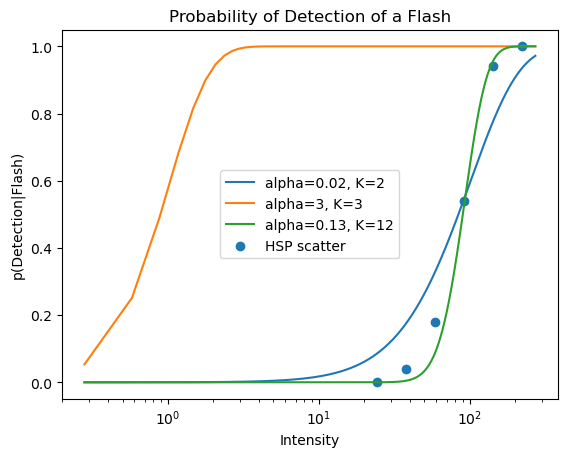

In [59]:
plotfit(search=False, alpha=(3), K=(3))

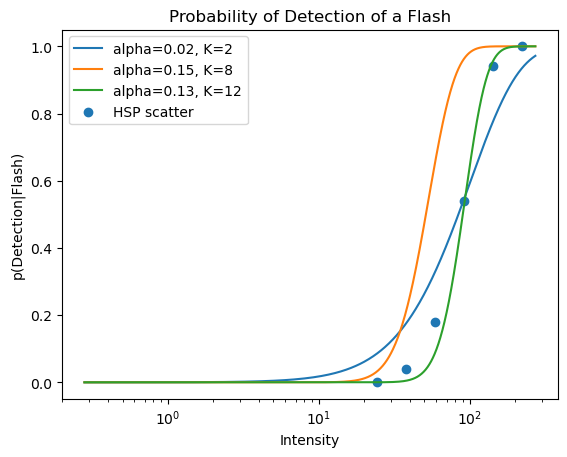

In [60]:
plotfit(search=False, alpha=0.15, K=8)

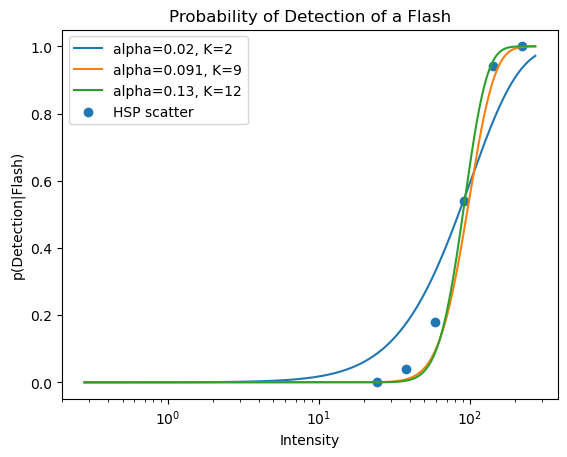

In [61]:
plotfit(search=False, alpha=0.091, K=9)

### Tests and self checks

You should write tests for your code and make plots to verify that your implementations are correct.  After you submit your draft version, take the self check quiz.  This will give you feedback so you can make corrections and revisions before you submit your final version.  Here are examples of the types of questions you can expect:

- conceptual questions from the readings and lectures
- questions from the assignment
- values of functions given specific parameters
- plots from the assignment given specific parameters

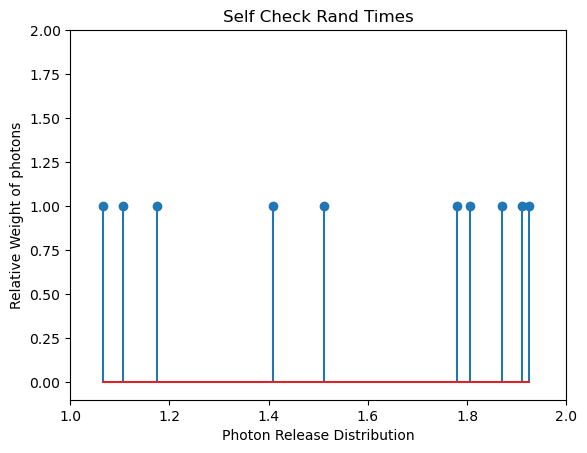

In [27]:
t = randtimes(N=10, t1=1, t2=2)
plotflash(t, title="Self Check Rand Times", xlim=[1, 2])

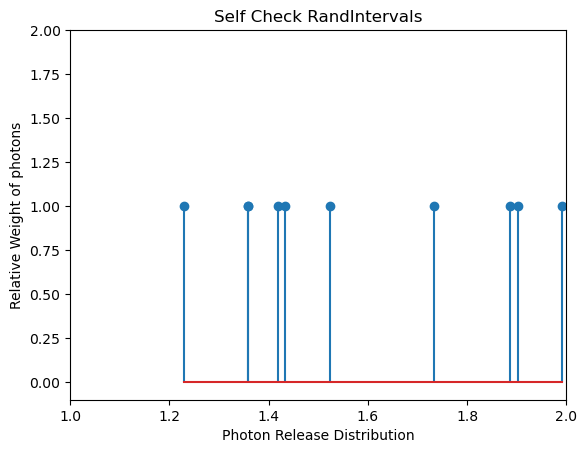

In [30]:
t = randintervals(N=10, lam=10, t1=1)
plotflash(t, title="Self Check RandIntervals", xlim=[1, 2])

In [31]:
detectionprob(3, 10, 0.1)

0.08030139707139416

In [32]:
detectionprob(6, 40, 0.1)

0.21486961296959484

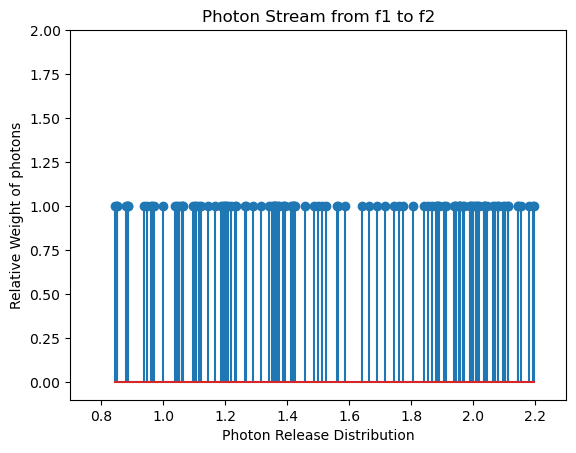

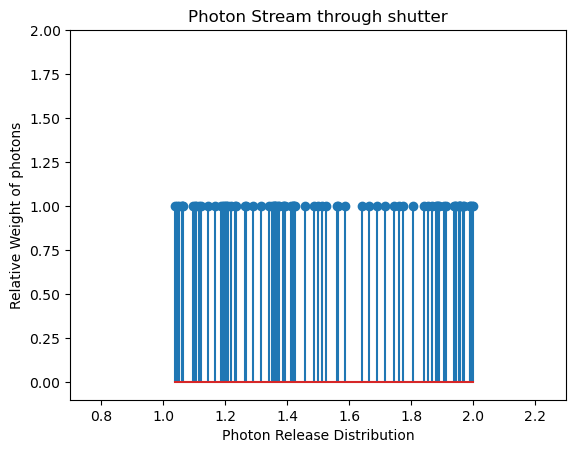

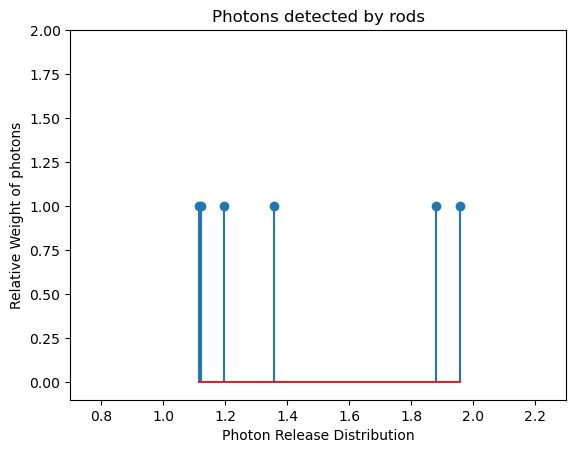

In [33]:
plotsimulation(lam=100, alpha=0.06, f1=0.8, f2=2.2, s1=1, s2=2)

***
### Submission Instructions

Please refer to the Assignment Submission Instructions on canvas under the Pages tab.